# <font color='blue'>Data Science Challenge @ ITA 2022</font>
# <font color='blue'>Equipe DIOMGIS</font>

## <font color='blue'>2º Fase</font>

### <font color='blue'>Construção de carteira composta por ativos que compõem o índice SP500.</font>

![title](data\image\logo.jpeg)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Bibliotecas e Frameworks

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
from hurst import compute_Hc, random_walk
from pykalman import KalmanFilter
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans

In [4]:
# Versões dos pacotes usados neste jupyter notebook

%reload_ext watermark
%watermark -a "Equipe DIOMGIS" --iversions

Author: Equipe DIOMGIS

numpy            : 1.22.3
pandas           : 1.4.2
seaborn          : 0.11.2
pandas_datareader: 0.10.0
matplotlib       : 3.5.1



In [5]:
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style("darkgrid")

In [6]:
# Parametros fixos de treinamento

quantAtivos = 10
verbose = 2
seed = 25
epochs = 2000
downloadData = False
timeBack = 500
benchmark = False
colors = sns.color_palette('pastel')[0:quantAtivos]


np.random.seed(seed)

In [7]:
setores = {
    'Industrials': ['MMM', 'AOS', 'ALK', 'ALLE', 'AAL', 'AME', 'BA',
                    'CHRW', 'CARR', 'CAT', 'CTAS', 'CPRT', 'CSGP',
                    'CSX', 'CMI', 'DE', 'DAL', 'DOV', 'ETN', 'EMR',
                    'EFX', 'EXPD', 'FAST', 'FDX', 'FTV', 'FBHS',
                    'GNRC', 'GD', 'GE', 'HON', 'HWM', 'HII', 'IEX',
                    'ITW', 'IR', 'JBHT', 'J', 'JCI', 'LHX', 'LDOS',
                    'LMT', 'MAS', 'NDSN', 'NSC', 'NOC', 'ODFL',
                    'OTIS', 'PCAR', 'PH', 'PNR', 'PWR', 'RTX', 'RSG',
                    'RHI', 'ROK', 'ROL', 'SNA', 'LUV', 'SWK', 'TXT',
                    'TT', 'TDG', 'UNP', 'UAL', 'UPS', 'URI', 'VRSK',
                    'WAB', 'WM', 'GWW', 'XYL'],
    
    'HealthCare': ['ABT', 'ABBV', 'ABMD', 'A', 'ALGN', 'ABC', 'AMGN',
                   'BAX', 'BDX', 'BIO', 'TECH', 'BIIB', 'BSX', 'BMY',
                   'CAH', 'CTLT', 'CNC', 'CRL', 'CI', 'COO', 'CVS',
                   'DHR', 'DVA', 'XRAY', 'DXCM', 'EW', 'ELV', 'LLY',
                   'GILD', 'HCA', 'HSIC', 'HOLX', 'HUM', 'IDXX',
                   'ILMN', 'INCY', 'ISRG', 'IQV', 'JNJ', 'LH', 'MCK',
                   'MDT', 'MRK', 'MTD', 'MRNA', 'MOH', 'OGN', 'PKI',
                   'PFE', 'DGX', 'REGN', 'RMD', 'STE', 'SYK', 'TFX',
                   'TMO', 'UNH', 'UHS', 'VRTX', 'VTRS', 'WAT',
                   'WST', 'ZBH', 'ZTS'],
    
    'InformationTechnology': ['ACN', 'ADBE', 'ADP', 'AKAM', 'AMD', 'APH',
                              'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET', 'ADSK',
                              'AVGO', 'BR', 'CDNS', 'CDW', 'CDAY', 'CSCO',
                              'CTSH', 'GLW', 'DXC', 'ENPH', 'EPAM', 'FFIV',
                              'FIS', 'FISV', 'FLT', 'FTNT', 'IT', 'GPN',
                              'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'JKHY',
                              'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MA', 'MCHP',
                              'MU', 'MSFT', 'MPWR', 'MSI', 'NTAP', 'NLOK',
                              'NVDA', 'NXPI', 'ON', 'ORCL', 'PAYX', 'PAYC',
                              'PYPL', 'PTC', 'QRVO', 'QCOM', 'ROP', 'CRM',
                              'STX', 'NOW', 'SWKS', 'SEDG', 'SNPS', 'TEL',
                              'TDY', 'TER', 'TXN', 'TRMB', 'TYL', 'VRSN',
                              'V', 'WDC', 'ZBRA'],
    
    'CommunicationServices': ['ATVI', 'GOOGL', 'GOOG', 'T', 'CHTR', 'CMCSA',
                              'DISH', 'DIS', 'EA', 'FOXA', 'FOX', 'IPG', 'LYV',
                              'LUMN', 'MTCH', 'META', 'NFLX', 'NWSA', 'NWS',
                              'OMC', 'PARA', 'TMUS', 'TTWO', 'TWTR', 'VZ', 'WBD'],
    
    'ConsumerStaples': ['ADM', 'MO', 'BF.B', 'CPB', 'CHD', 'CLX', 'KO', 'CL',
                        'CAG', 'STZ', 'COST', 'EL', 'GIS', 'HSY', 'HRL', 'K',
                        'KDP', 'KMB', 'KHC', 'KR', 'LW', 'MKC', 'TAP', 'MDLZ',
                        'MNST', 'PEP', 'PM', 'PG', 'SJM', 'SYY', 'TSN', 'WBA',
                        'WMT'],
    
    'ConsumerDiscretionary': ['AAP', 'AMZN', 'APTV', 'AZO', 'BBWI',
                              'BBY', 'BKNG', 'BWA', 'CZR', 'KMX', 'CCL',
                              'CMG', 'DHI', 'DRI', 'DG', 'DLTR',
                              'DPZ', 'EBAY', 'ETSY', 'EXPE', 'F',
                              'GRMN', 'GM', 'GPC', 'HAS', 'HLT', 'HD',
                              'LVS', 'LEN', 'LKQ', 'LOW', 'MAR', 'MCD',
                              'MGM', 'MHK', 'NWL', 'NKE', 'NCLH', 'NVR',
                              'ORLY', 'POOL', 'PHM', 'RL', 'ROST', 'RCL',
                              'SBUX', 'TPR', 'TGT', 'TSLA', 'TJX',
                              'TSCO', 'ULTA', 'VFC', 'WHR', 'WYNN', 'YUM'],
    
    'Utilities': ['AES', 'LNT', 'AEE', 'AEP', 'AWK', 'ATO', 'CNP',
                  'CMS', 'ED', 'CEG', 'D', 'DTE', 'DUK', 'EIX',
                  'ETR', 'EVRG', 'ES', 'EXC', 'FE', 'NEE', 'NI',
                  'NRG', 'PCG', 'PNW', 'PPL', 'PEG', 'SRE', 'SO',
                  'WEC', 'XEL'],
    
    'Financials': ['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG',
                   'AIZ', 'BAC', 'WRB', 'BRK.B', 'BLK', 'BK', 'BRO',
                   'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG',
                   'CME', 'CMA', 'DFS', 'RE', 'FDS', 'FITB', 'FRC',
                   'BEN', 'GL', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ',
                   'JPM', 'KEY', 'LNC', 'L', 'MTB', 'MKTX', 'MMC',
                   'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PNC',
                   'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'SBNY',
                   'STT', 'SIVB', 'SYF', 'TROW', 'TRV', 'TFC',
                   'USB', 'WFC', 'WTW', 'ZION',  'NLSN'],
    
    'Materials': ['APD', 'ALB', 'AMCR', 'AVY', 'BALL', 'CE', 'CF',
                  'CTVA', 'DOW', 'DD', 'EMN', 'ECL', 'FMC', 'FCX',
                  'IP', 'IFF', 'LIN', 'LYB', 'MLM', 'MOS', 'NEM',
                  'NUE', 'PKG', 'PPG', 'SEE', 'SHW', 'VMC', 'WRK'],
    
    'RealEstate': ['ARE', 'AMT', 'AVB', 'BXP', 'CPT', 'CBRE', 'CCI',
                   'DLR', 'EQIX', 'EQR', 'ESS', 'EXR', 'FRT', 'PEAK',
                   'HST', 'INVH', 'IRM', 'KIM', 'MAA', 'PLD', 'PSA',
                   'O', 'REG', 'SBAC', 'SPG', 'UDR', 'VTR', 'VICI',
                   'VNO', 'WELL', 'WY'],
    
    'Energy': ['APA','BKR', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG',
               'EQT', 'XOM', 'HAL', 'HES', 'KMI', 'MRO', 'MPC', 'OXY',
               'OKE', 'PSX', 'PXD', 'SLB', 'VLO', 'WMB']
}

In [8]:
ativos = []
for setor, empresas in setores.items():
    ativos.extend(empresas)
    
ativos.sort()

### Download dos Dados

In [9]:
if downloadData:

    start_date = "2017-10-21"
    end_date = "2022-10-21"

    data = web.DataReader(name = '^GSPC', data_source = 'yahoo', start = start_date, end = end_date)
    SP500_index = pd.DataFrame(data['Close']).reset_index().rename(columns={'Close': 'SP500', 'Date': 'Dia'})

    SP500_close = pd.DataFrame()

    for ativo in ativos:
  
        if ativo == 'BF.B':
            ativo = 'BF-B'

        if ativo == 'BRK.B':
            ativo = 'BRK-B'

        data = web.DataReader(name = ativo, data_source = 'yahoo', start = start_date, end = end_date)
        temp_close = pd.DataFrame(data['Close'])
        SP500_close = pd.concat([SP500_close, temp_close], axis = 1)

        
    SP500_close.columns = ativos
    SP500_close.reset_index(inplace = True)
    SP500_close.rename(columns={'Date': 'Dia'}, inplace = True)

    outdir = './data/{}-{}'.format(start_date, end_date)

    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    SP500_close.to_csv(path_or_buf = os.path.join(outdir, 'SP500_close'), index = False)
    SP500_index.to_csv(path_or_buf = os.path.join(outdir, 'SP500_index'), index = False)
    
else:
    SP500_close = pd.read_csv('./data/train/SP500Close.csv')
    SP500_close = SP500_close.set_index("Dia")
    SP500_close.index = pd.to_datetime(SP500_close.index)
    SP500_index = pd.read_csv('./data/train/SP500Index.csv')
    SP500_index = SP500_index.set_index("Dia")
    SP500_index.index = pd.to_datetime(SP500_index.index)

## Pré-Processamento dos Dados

In [10]:
df = SP500_close.copy()

In [11]:
if benchmark:
    df = df[df.index < '2019-10-20']
    SP500_index = SP500_index[SP500_index.index < '2019-10-20']
    
else:
    df = df[df.index > '2020-10-19']
    SP500_index = SP500_index[SP500_index.index > '2020-10-19']

In [12]:
df.isna().any().sum()

2

In [13]:
df = df.fillna(method = 'backfill', axis = 'columns')

In [14]:
df.isna().any().sum()

0

In [15]:
scaler = StandardScaler()

In [16]:
scaler.fit(df)

StandardScaler()

In [17]:
dfScalerNP = scaler.transform(df)

In [18]:
dfScaled = pd.DataFrame(dfScalerNP, columns = df.columns, index = df.index)

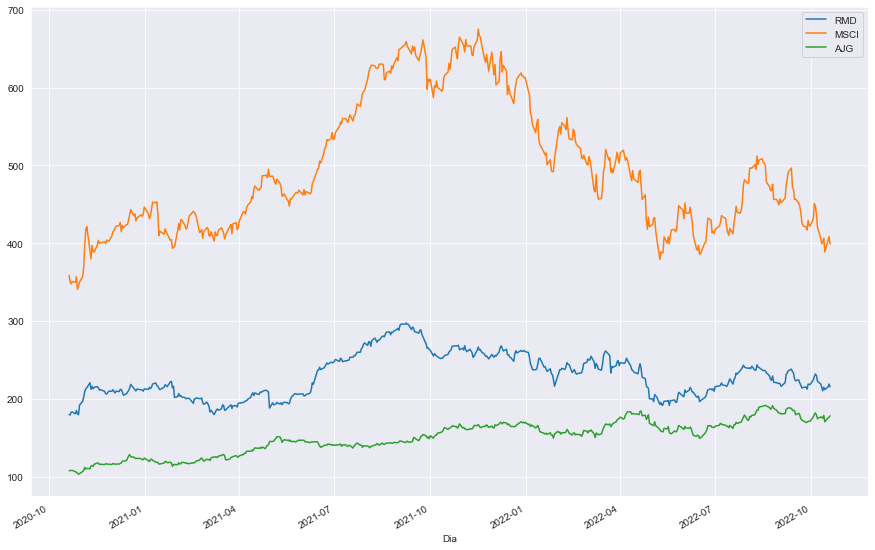

In [19]:
df.T.sample(3, random_state = 14).T.plot();

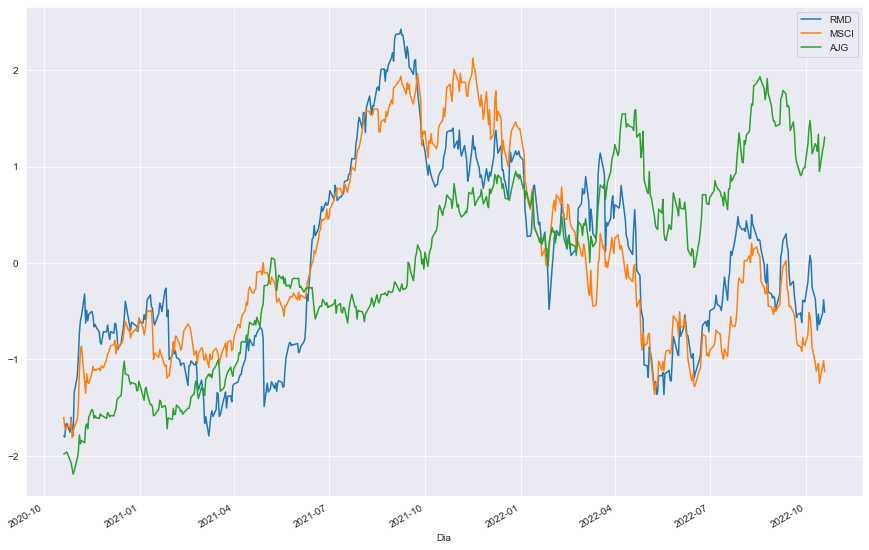

In [20]:
dfScaled.T.sample(3, random_state = 14).T.plot();

In [21]:
kmeans = KMeans(n_clusters = quantAtivos,
                n_init = 10 ,
                max_iter = 300,
                tol = 0.0001,
                verbose = 2,
                random_state = seed,
                algorithm = 'lloyd') # “lloyd”, “elkan”

In [22]:
kmeans.fit(dfScalerNP.T)

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Initialization complete
Iteration 0, inertia 105869.01269770256.
Iteration 1, inertia 72445.84025718793.
Iteration 2, inertia 70449.22939959951.
Iteration 3, inertia 69936.43649586408.
Iteration 4, inertia 69681.37051401145.
Iteration 5, inertia 69451.6172131283.
Iteration 6, inertia 69320.96886377879.
Iteration 7, inertia 69219.07025546717.
Iteration 8, inertia 69132.82683058834.
Iteration 9, inertia 69096.9839741058.
Iteration 10, inertia 69074.21907593979.
Iteration 11, inertia 69042.76924645029.
Iteration 12, inertia 69027.38088954201.
Iteration 13, inertia 69015.82561903312.
Iteration 14, inertia 68980.56260361275.
Iteration 15, inertia 68948.08850051527.
Iteration 16, inertia 68922.19758741686.
Iteration 17, inertia 68901.18925354638.
Iteration 18, inertia 68876.7615013624.
Iteration 19, inertia 68857.51992463588.
Iteration 20, inertia 68845.76176086284.
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 105605.4910552137.
Iteration 1, ine

KMeans(n_clusters=10, random_state=25, verbose=2)

In [23]:
SP500IndexPct = SP500_index.pct_change().dropna()['SP500']

obs_matriz = np.expand_dims(np.vstack([[SP500IndexPct],
                                       [np.ones(len(SP500IndexPct))]]).T, axis = 1)

kf = KalmanFilter(initial_state_mean = [0, 0],
                  initial_state_covariance = np.ones((2, 2)),
                  transition_matrices = np.eye(2),
                  observation_matrices = obs_matriz)

In [24]:
selectGroup = []
ativosGroup = []
meanGroup = []
columns = []
regressAtivo = pd.DataFrame(index = ativos, columns = ['coefAng', 'RScore', 'Setor', "meanBeta", "H", "c", 'Group', 'Growth'])

x = np.arange(0, timeBack, 1, dtype = int).reshape(-1, 1)
time = datetime.now().strftime('%d-%B-%Ih%Mmin')

outdir = './graphics/2º Fase/{}'.format(time)

os.mkdir(outdir)
os.mkdir(outdir + '/ativos')

outdirtivos = outdir + '/ativos'
    
for i in range(quantAtivos):
    columns.append('Grupo {}'.format(i))
    
for group in np.unique(kmeans.labels_, return_counts=True)[0]:
    filter = kmeans.labels_ == group
    selectGroup.append(filter)
    ativosGroup.append(dfScaled.T[filter].index)
    meanGroup.append(dfScaled.T[filter].mean())
    
    
setorGroups = pd.DataFrame(np.zeros(shape = (len(setores), len(selectGroup)), dtype = int),
                           index = setores.keys(),
                           columns = columns)
    
for group in range(len(ativosGroup)):
    for ativo in ativosGroup[group]:
        for setor in setores.keys():
            if ativo in setores[setor]:
                setorGroups.loc[setor, setorGroups.columns[group]] += 1
                
                growth = (df.loc[df.index[-1], ativo] / df.loc[df.index[-timeBack], ativo]) - 1 
                
                model = LinearRegression()
                aux = dfScaled[ativo].to_numpy().reshape(-1, 1)[-timeBack:]
                model.fit(x, aux)
                pred = model.predict(x)
                
                
                stateMeans, stateCovs = kf.filter(dfScaled[ativo].pct_change().dropna())
                H, c, data = compute_Hc(dfScaled[ativo].to_numpy() + 10, kind='price', simplified=True)
                
                fig, ax = plt.subplots()
                ax.plot(dfScaled[ativo].index, dfScaled[ativo], linewidth=1.0, c = 'b')
                ax.plot(dfScaled[ativo].index[-timeBack:], pred, linewidth=2.0, c = 'r', ls = '--')
                ax.set_title("Ativo: {} | Coeficiente Angular: {:.3f} | Expoente de Hurst: {:.3f} | Crescimento: {:.1f}% "\
                             .format(ativo, model.coef_[0][0], H, 100 * growth))
                ax.set(xlabel='Data', ylabel='Preço Normalizado($)')
                nameGraphic = '{}.png'.format(ativo)
                fullname = os.path.join(outdirtivos, nameGraphic)
                plt.savefig(fullname)
                plt.close(fig)
                
                regressAtivo.loc[ativo, 'RScore'] = model.score(x, aux)
                regressAtivo.loc[ativo, 'coefAng'] = model.coef_[0][0]
                regressAtivo.loc[ativo, 'Setor'] = setor
                regressAtivo.loc[ativo, "H"] = H
                regressAtivo.loc[ativo, "c"] = c
                regressAtivo.loc[ativo, "meanBeta"] = stateMeans[:, 0].mean()
                regressAtivo.loc[ativo, "Group"] = group
                regressAtivo.loc[ativo, "Growth"] = growth

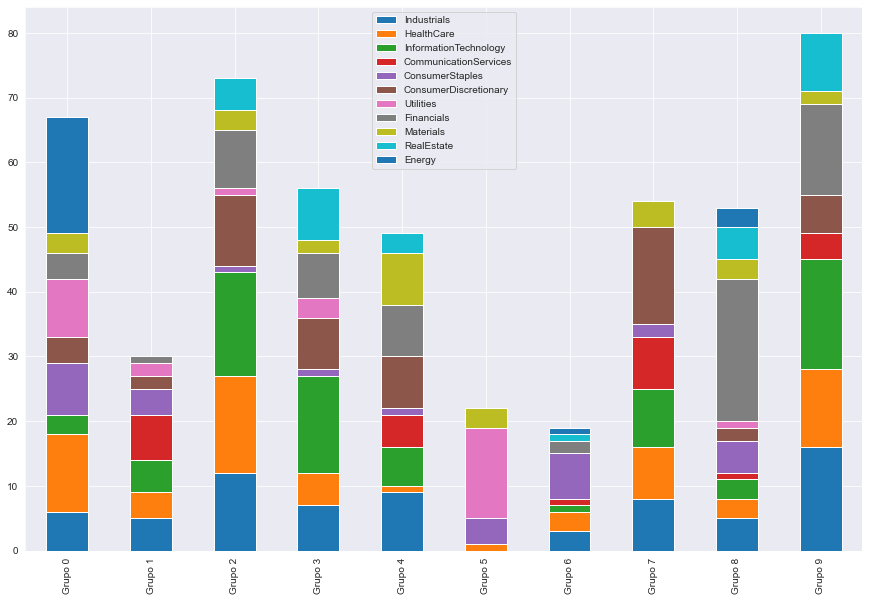

In [25]:
setorGroups.T.plot.bar(stacked=True);

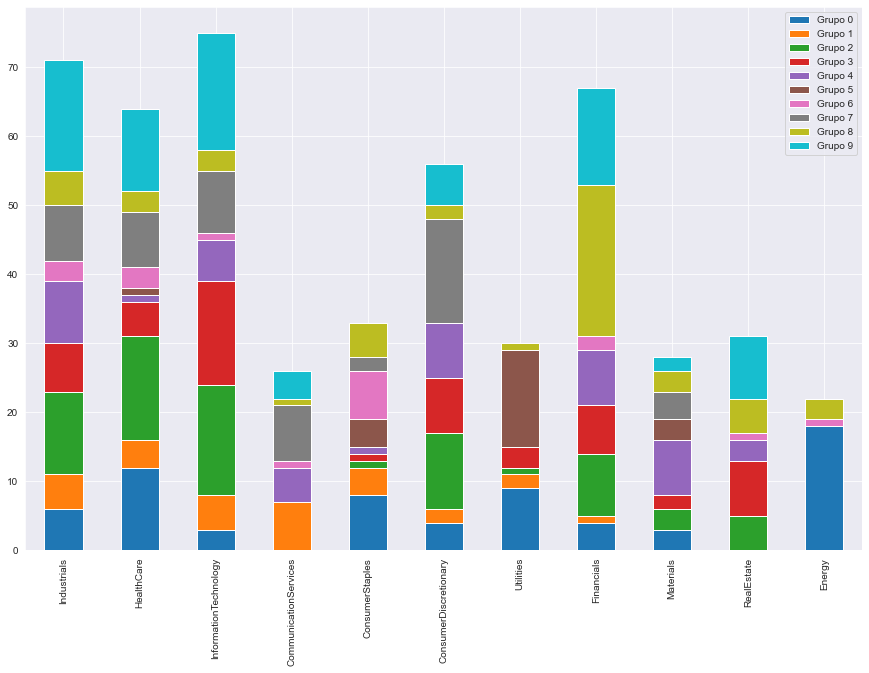

In [26]:
setorGroups.plot.bar(stacked=True);

In [27]:
mediaDF = pd.DataFrame(index = columns, columns = ["H", "c", "meanBeta"])
historicBeta = []

In [28]:
for group in range(quantAtivos):
    H, c, data = compute_Hc(meanGroup[group].to_numpy() + 10, kind='price', simplified=True)

    
    mediaDF.loc[mediaDF.index[group], "H"] = H
    mediaDF.loc[mediaDF.index[group], "c"] = c
    
    stateMeans, stateCovs = kf.filter(meanGroup[group].pct_change().dropna())
    
    mediaDF.loc[mediaDF.index[group], "meanBeta"] = stateMeans[:, 0].mean()
    historicBeta.append(stateMeans[:, 0])
    

    fig, ax = plt.subplots()
    ax.plot(SP500IndexPct.index, stateMeans[:, 0])
    ax.set_title("GRUPO {}".format(group))
    ax.set(xlabel='Data', ylabel = 'Coeficiente Beta')
    nameGraphic = '{} Coeficiente Beta.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
    
    stl = STL(meanGroup[group], period=365).fit()
    
    fig = stl.plot()
    ax.set_title("GRUPO {}".format(group))
    nameGraphic = '{} STL.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
       
    fig, ax = plt.subplots()
    dfScaled.T[selectGroup[group]].T.plot(ax = ax)
    ax.set_title("GRUPO {}".format(group))
    ax.set(xlabel='Data', ylabel='Preço Normalizado($)')
    nameGraphic = '{} Grupo.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
    
    fig, ax = plt.subplots()
    meanGroup[group].plot(ax = ax)
    ax.set_title("MEDIA GRUPAL {} / Expoente de Hurst: {:.3f}".format(group, H))
    ax.set(xlabel='Data', ylabel='Preço Normalizado($)')
    nameGraphic = '{} Media Grupal.png'.format(group)
    fullname = os.path.join(outdir, nameGraphic)
    plt.savefig(fullname)
    plt.close(fig)
#------------------------------------------------------------------------------------------------------------

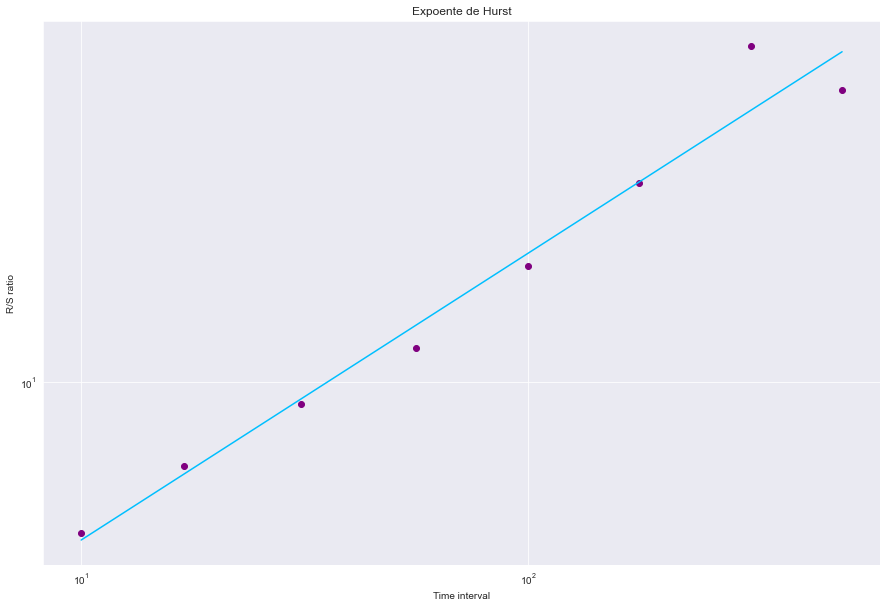

In [29]:
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_title("Expoente de Hurst")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

In [30]:
mediaDF

,H,c,meanBeta
Grupo 0,0.694006,0.779658,2.884711
Grupo 1,0.594701,1.049175,1.599807
Grupo 2,0.619987,1.055442,-1.762967
Grupo 3,0.665356,0.942962,2.714221
Grupo 4,0.596827,1.039121,11.534923
Grupo 5,0.481821,1.561361,1.300007
Grupo 6,0.645221,0.886196,1.894328
Grupo 7,0.612033,0.974666,15.623234
Grupo 8,0.700422,0.764466,-53.632465
Grupo 9,0.69237,0.845234,2.832864


In [31]:
regressAtivo

,coefAng,RScore,Setor,meanBeta,H,c,Group,Growth
A,0.000587,0.007307,HealthCare,1.306716,0.635899,1.025697,2,0.232534
AAL,-0.002763,0.160579,Industrials,-90.474637,0.564839,1.143205,4,0.185593
AAP,0.002235,0.105416,ConsumerDiscretionary,-7.101227,0.574744,1.075041,9,0.132531
AAPL,0.00474,0.475188,InformationTechnology,-24.743965,0.562913,1.170747,3,0.250413
ABBV,0.005931,0.753093,HealthCare,-1.201206,0.721515,0.71746,0,0.705553
...,...,...,...,...,...,...,...,...
YUM,0.002264,0.109299,ConsumerDiscretionary,-11.676368,0.625812,0.901989,9,0.113407
ZBH,-0.00589,0.717208,HealthCare,-2.902531,0.575043,0.998857,1,-0.201752
ZBRA,-0.002615,0.14355,InformationTechnology,0.262449,0.666968,0.892187,2,-0.117384
ZION,0.003174,0.222826,Financials,13.514294,0.643492,0.873628,8,0.516328


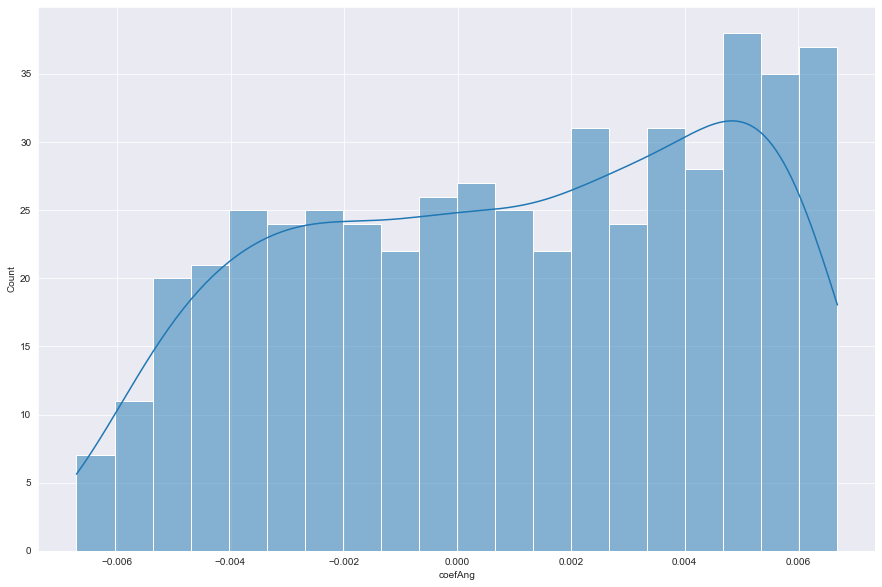

In [32]:
sns.histplot(data = regressAtivo, x="coefAng", kde=True, bins= 20);

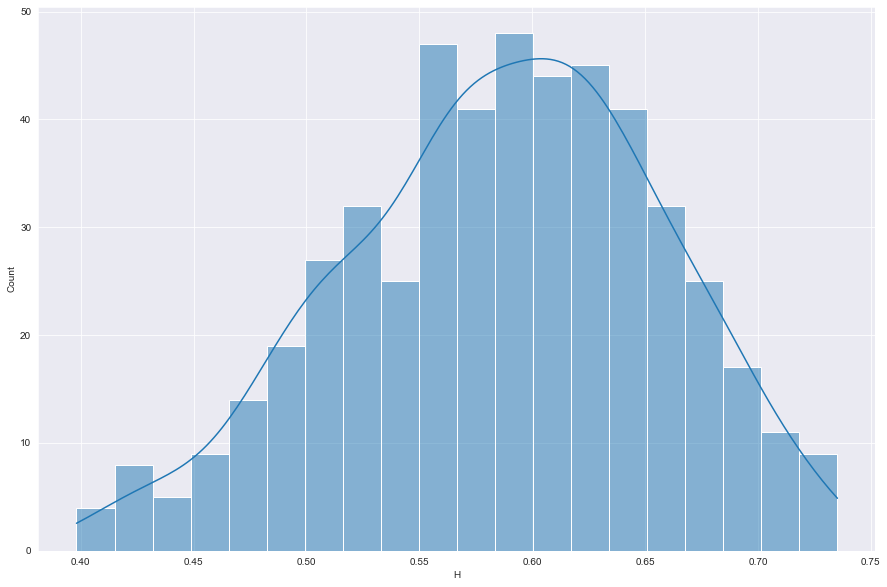

In [33]:
sns.histplot(data = regressAtivo, x="H", kde=True, bins= 20);

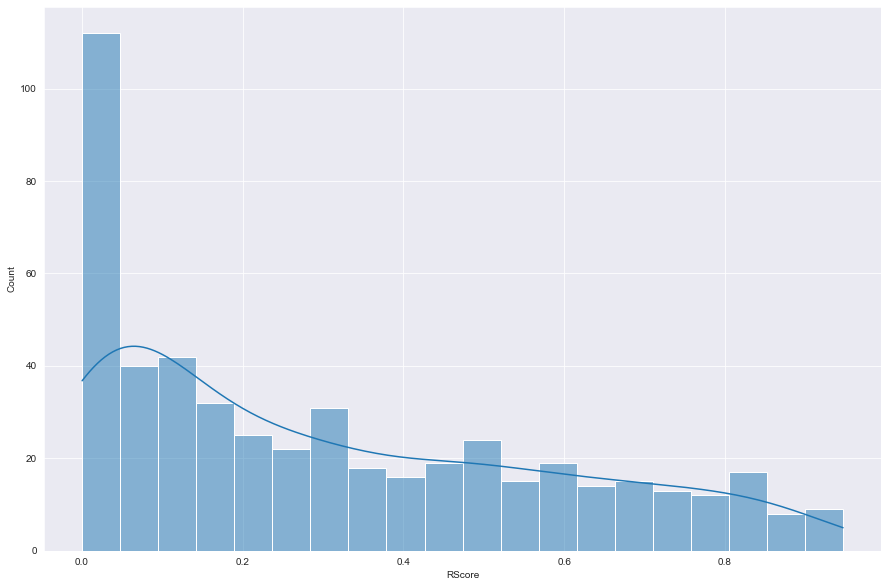

In [34]:
sns.histplot(data = regressAtivo, x="RScore", kde=True, bins = 20);

In [35]:
regressAtivo = regressAtivo[regressAtivo['H'] > 0.55]

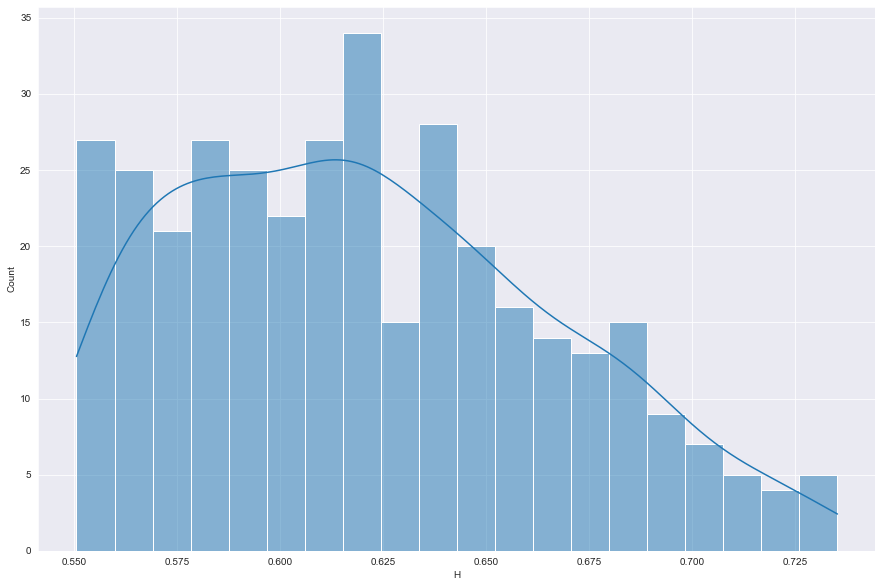

In [36]:
sns.histplot(data = regressAtivo, x="H", kde=True, bins= 20);

In [37]:
choice = []

for group in range(quantAtivos):
    first = regressAtivo[regressAtivo['Group'] == group].sort_values(by='coefAng', ascending=False).index[0]
    choice.append(first)

In [38]:
tempAux = []

for index in regressAtivo.index:
    if index in choice:
        tempAux.append(True)
    
    else:
        tempAux.append(False)

In [39]:
wallet = regressAtivo[tempAux]
wallet

,coefAng,RScore,Setor,meanBeta,H,c,Group,Growth
AMT,0.00118,0.028837,RealEstate,-12.321893,0.583552,1.269032,2,-0.194543
CVS,0.005865,0.740258,HealthCare,2.58546,0.682492,0.808891,8,0.538952
HII,0.004764,0.490648,Industrials,20.561137,0.614998,0.971755,6,0.624073
HSY,0.006691,0.941082,ConsumerStaples,-1.346646,0.701845,0.681408,0,0.569071
OMC,0.001057,0.024426,CommunicationServices,-7.393915,0.654242,0.852082,4,0.33509
ORLY,0.006292,0.832189,ConsumerDiscretionary,-10.056203,0.62339,0.953903,3,0.617949
PAYC,-0.002967,0.181975,InformationTechnology,-49.241856,0.5521,1.233509,7,-0.153057
PG,0.002924,0.176686,ConsumerStaples,-5.280365,0.556183,1.200906,5,-0.083086
PTC,-0.002697,0.157344,InformationTechnology,3.610667,0.566114,1.161282,1,0.298195
TXT,0.003662,0.296296,Industrials,-65.309222,0.706786,0.694253,9,0.818289


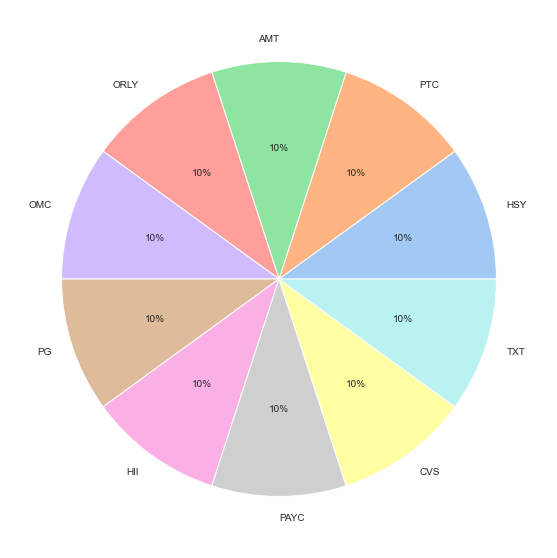

In [40]:
data = np.ones(quantAtivos) * (1/quantAtivos)

colors = sns.color_palette('pastel')[0:quantAtivos]

#create pie chart
plt.pie(data, labels = choice, colors = colors, autopct='%.0f%%')
plt.show()

In [41]:
weight = pd.Series(index = wallet.index)

In [42]:
weightTot = 1
growthSum = 0
nPos = 0
transition = 0.10

for ativo in choice:
    if wallet.loc[ativo, 'Growth'] <= transition:
        weight[ativo] = 0.05
        weightTot -= 0.05
    
    else:
        growthSum += wallet.loc[ativo, 'Growth']
        nPos += 1

In [43]:
growthMean = growthSum / nPos

In [44]:
for ativo in choice:
    if wallet.loc[ativo, 'Growth'] > transition:
        weight[ativo] = (wallet.loc[ativo, 'Growth'] / growthSum) * weightTot

In [45]:
weight

AMT     0.050000
CVS     0.120504
HII     0.139536
HSY     0.127238
OMC     0.074922
ORLY    0.138167
PAYC    0.050000
PG      0.050000
PTC     0.066673
TXT     0.182960
dtype: float64

In [46]:
weight.sum()

1.0

### Por que ponderar em função do coeficiente angular da regressão do preço e não do preço padronizado?

In [47]:
asset1 = 'HII'
asset2 = 'ORLY'

[Text(0.5, 0, 'Data'), Text(0, 0.5, 'Preço Padronizado')]

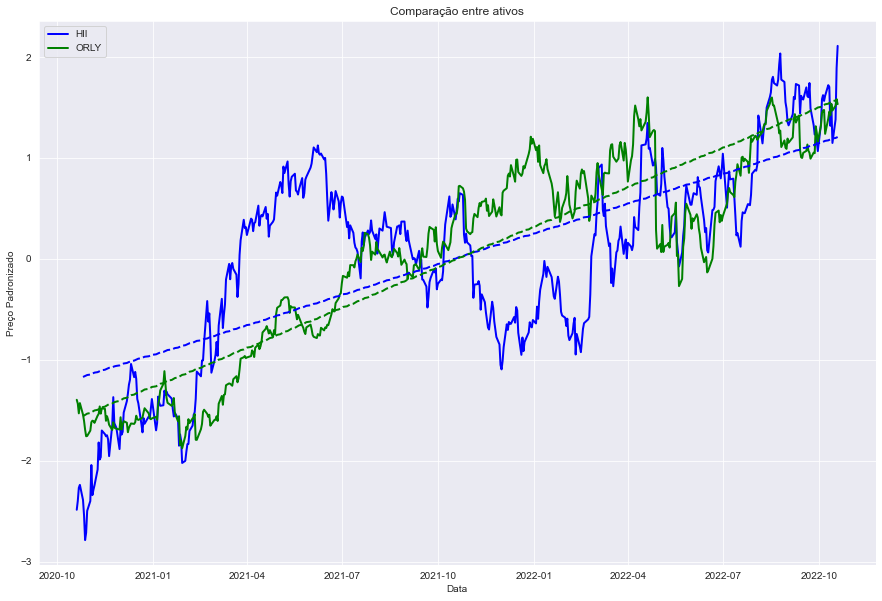

In [48]:
model1 = LinearRegression()
model2 = LinearRegression()

aux1 = dfScaled[asset1].to_numpy().reshape(-1, 1)[-timeBack:]
aux2 = dfScaled[asset2].to_numpy().reshape(-1, 1)[-timeBack:]

model1.fit(x, aux1)
model2.fit(x, aux2)

pred1 = model1.predict(x)
pred2 = model2.predict(x)
                
fig, ax = plt.subplots()
ax.plot(dfScaled[asset1], linewidth = 2.0, c = 'b')
ax.plot(dfScaled[asset2], linewidth = 2.0, c = 'g')
ax.plot(dfScaled.index[-timeBack:], pred1, linewidth = 2.0, c = 'b', ls = '--')
ax.plot(dfScaled.index[-timeBack:], pred2, linewidth = 2.0, c = 'g', ls = '--')
ax.legend([asset1, asset2])

ax.set_title("Comparação entre ativos")
ax.set(xlabel='Data', ylabel = 'Preço Padronizado')

[Text(0.5, 0, 'Data'), Text(0, 0.5, 'Preço')]

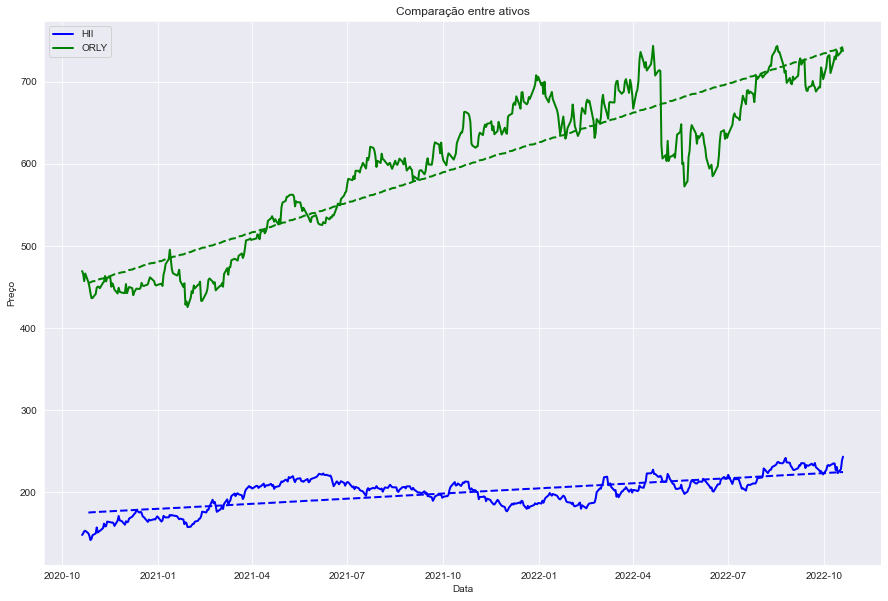

In [49]:
model1 = LinearRegression()
model2 = LinearRegression()

aux1 = df[asset1].to_numpy().reshape(-1, 1)[-timeBack:]
aux2 = df[asset2].to_numpy().reshape(-1, 1)[-timeBack:]

model1.fit(x, aux1)
model2.fit(x, aux2)

pred1 = model1.predict(x)
pred2 = model2.predict(x)
                
fig, ax = plt.subplots()
ax.plot(df[asset1], linewidth = 2.0, c = 'b')
ax.plot(df[asset2], linewidth = 2.0, c = 'g')
ax.plot(df.index[-timeBack:], pred1, linewidth = 2.0, c = 'b', ls = '--')
ax.plot(df.index[-timeBack:], pred2, linewidth = 2.0, c = 'g', ls = '--')
ax.legend([asset1, asset2])

ax.set_title("Comparação entre ativos")
ax.set(xlabel='Data', ylabel = 'Preço')


In [50]:
wallet

,coefAng,RScore,Setor,meanBeta,H,c,Group,Growth
AMT,0.00118,0.028837,RealEstate,-12.321893,0.583552,1.269032,2,-0.194543
CVS,0.005865,0.740258,HealthCare,2.58546,0.682492,0.808891,8,0.538952
HII,0.004764,0.490648,Industrials,20.561137,0.614998,0.971755,6,0.624073
HSY,0.006691,0.941082,ConsumerStaples,-1.346646,0.701845,0.681408,0,0.569071
OMC,0.001057,0.024426,CommunicationServices,-7.393915,0.654242,0.852082,4,0.33509
ORLY,0.006292,0.832189,ConsumerDiscretionary,-10.056203,0.62339,0.953903,3,0.617949
PAYC,-0.002967,0.181975,InformationTechnology,-49.241856,0.5521,1.233509,7,-0.153057
PG,0.002924,0.176686,ConsumerStaples,-5.280365,0.556183,1.200906,5,-0.083086
PTC,-0.002697,0.157344,InformationTechnology,3.610667,0.566114,1.161282,1,0.298195
TXT,0.003662,0.296296,Industrials,-65.309222,0.706786,0.694253,9,0.818289


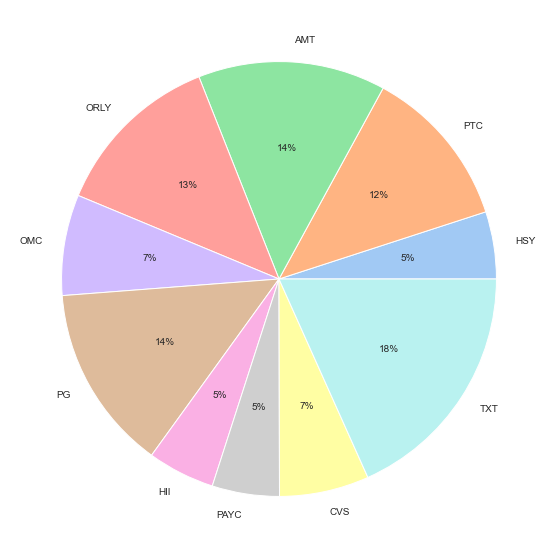

In [51]:
#create pie chart
plt.pie(weight, labels = choice, colors = colors, autopct='%.0f%%')
plt.show()

## Benchmark

In [52]:
# future = SP500_close[(SP500_close.index > '2019-10-20') & (SP500_close.index < '2021-10-20')]
future = SP500_close[(SP500_close.index > '2019-10-20')]

In [53]:
future.loc[:, choice]

,HSY,PTC,AMT,ORLY,OMC,PG,HII,PAYC,CVS,TXT
Dia,,,,,,,,,,
2019-10-21,153.580002,66.120003,229.399994,402.470001,75.379997,119.080002,211.009995,206.029999,65.699997,47.209999
2019-10-22,149.750000,65.940002,226.740005,400.399994,76.470001,122.180000,215.160004,190.600006,66.559998,46.639999
2019-10-23,149.710007,66.889999,226.020004,400.529999,76.720001,123.000000,217.160004,194.610001,65.599998,46.790001
2019-10-24,146.369995,69.949997,223.470001,437.299988,76.489998,124.790001,220.720001,203.500000,64.839996,46.750000
2019-10-25,143.309998,67.750000,216.669998,438.540009,76.820000,123.250000,221.190002,209.669998,65.099998,47.259998
...,...,...,...,...,...,...,...,...,...,...
2022-10-13,227.800003,108.169998,189.850006,737.979980,67.870003,126.309998,230.660004,313.440002,90.099998,61.750000
2022-10-14,222.710007,105.570000,185.779999,731.909973,66.669998,125.080002,223.169998,298.730011,89.300003,59.840000
2022-10-17,225.720001,108.389999,192.490005,736.270020,67.519997,127.339996,228.009995,315.660004,90.889999,61.750000


In [54]:
variationAssets = (future.loc[future.index[-1], choice] - future.loc[future.index[0], choice])
variationAssets

HSY      72.679993
PTC      42.500000
AMT     -38.409988
ORLY    335.249969
OMC      -6.969994
PG       10.479996
HII      32.130005
PAYC    114.470001
CVS      25.960007
TXT      14.630001
dtype: float64

In [55]:
variationAssets.sum()

602.7199897766113

In [56]:
variationWallet = variationAssets * weight
variationWallet

AMT     -1.920499
CVS      3.128279
HII      4.483288
HSY      9.247651
OMC     -0.522208
ORLY    46.320330
PAYC     5.723500
PG       0.524000
PTC      2.833610
TXT      2.676710
dtype: float64

In [57]:
variationWallet.sum()

72.49465988960968

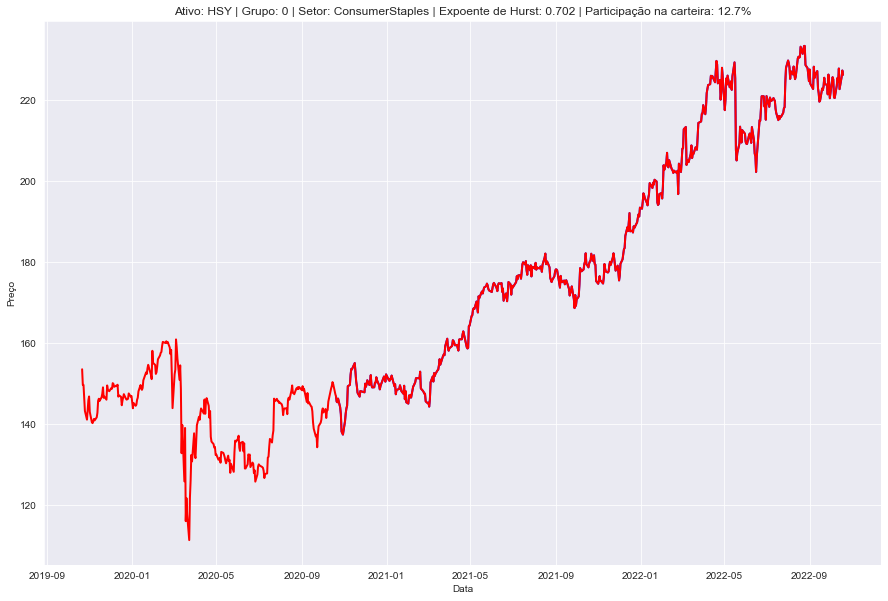

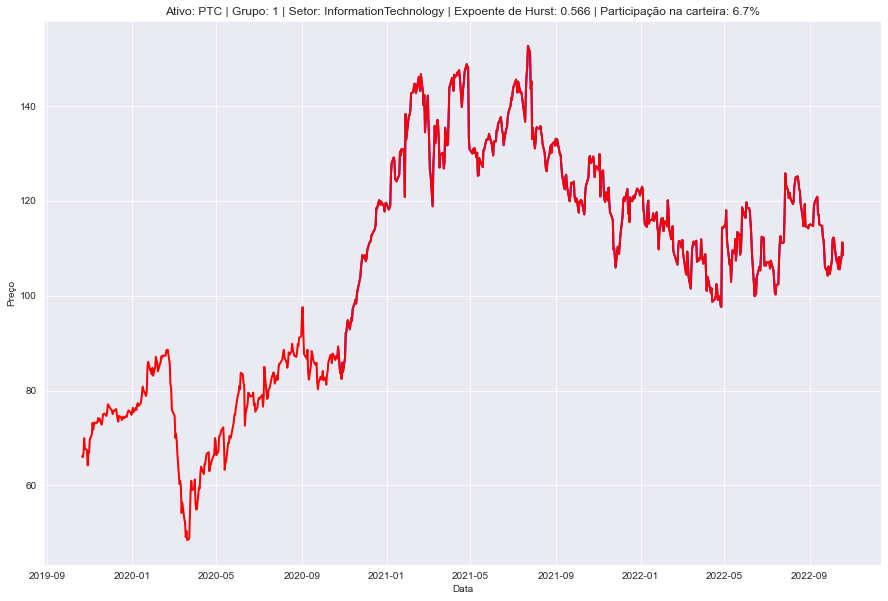

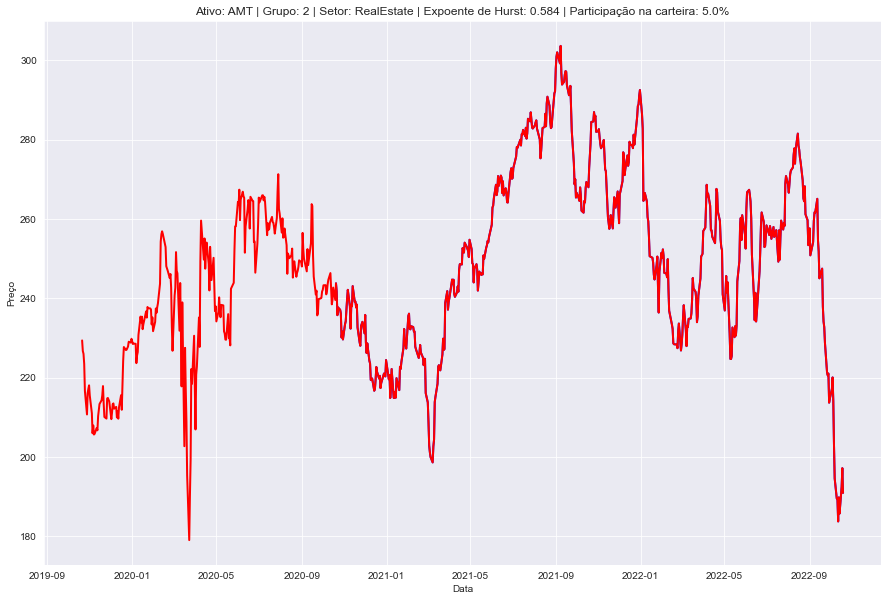

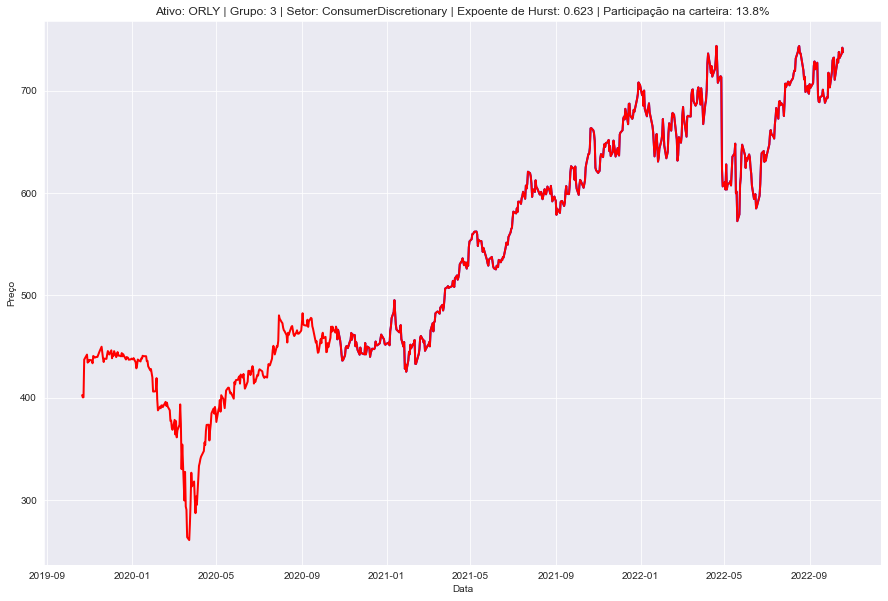

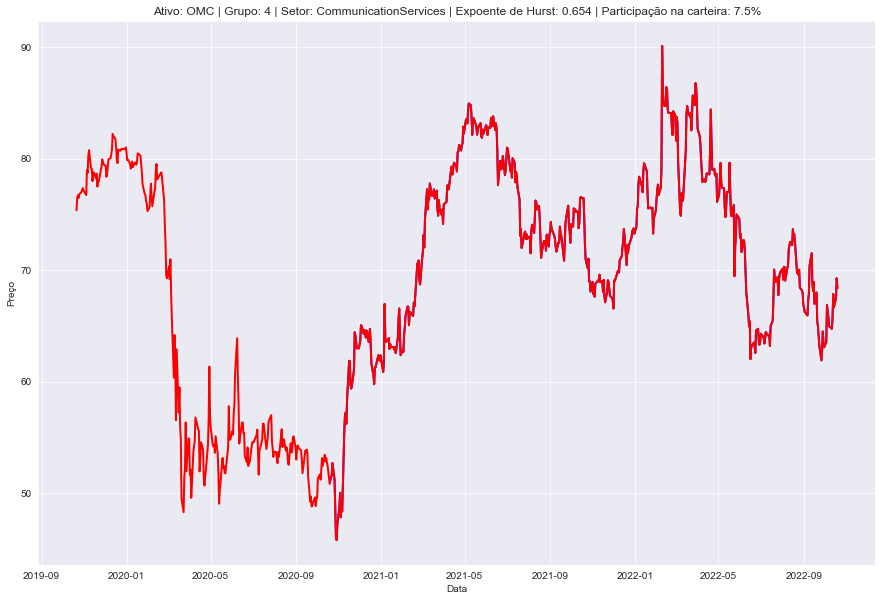

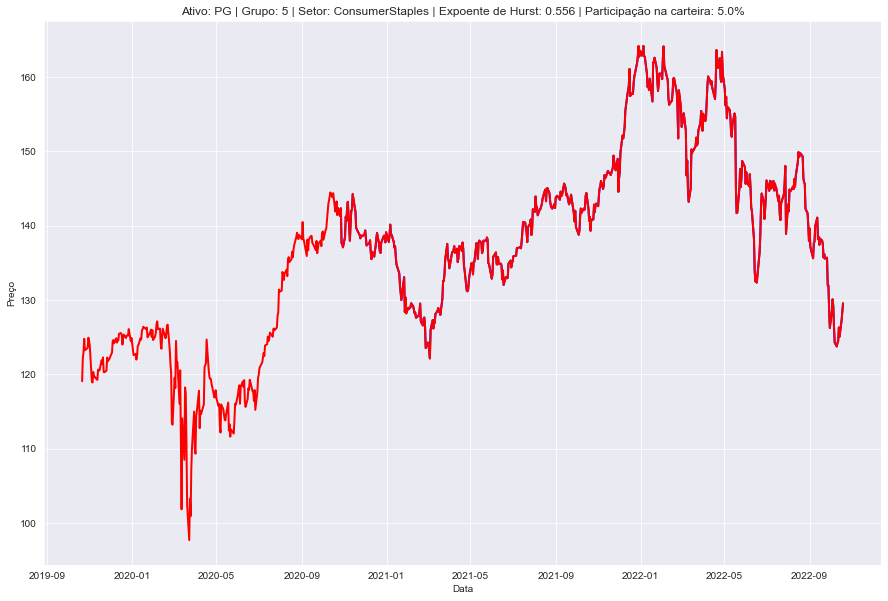

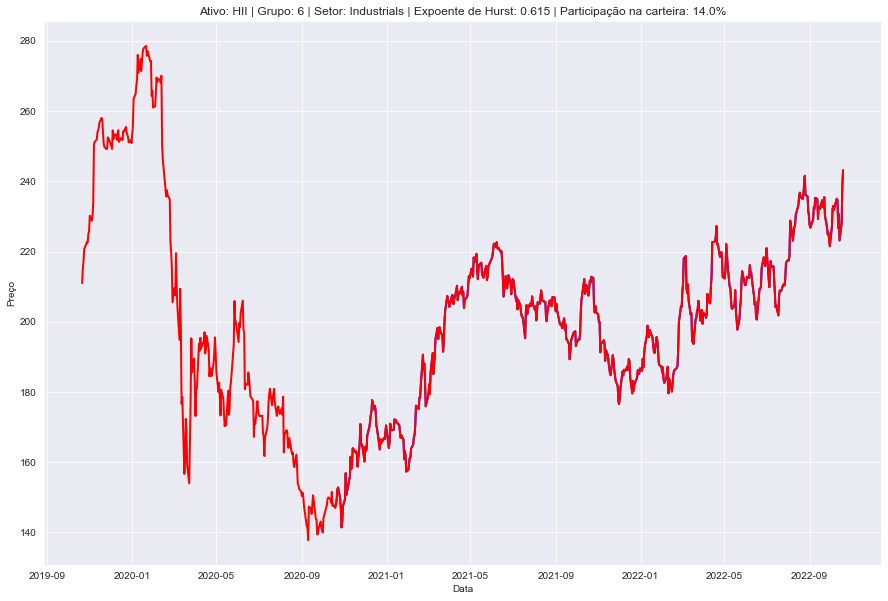

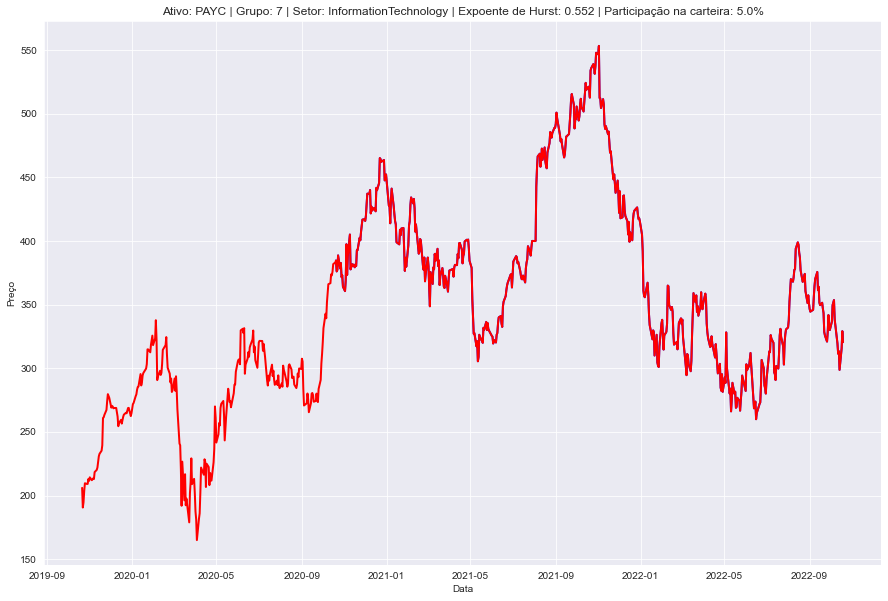

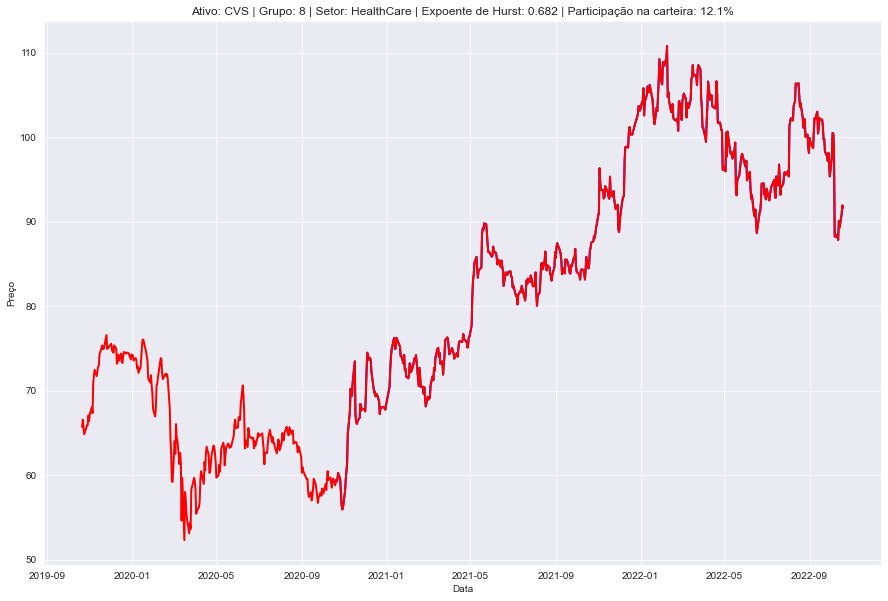

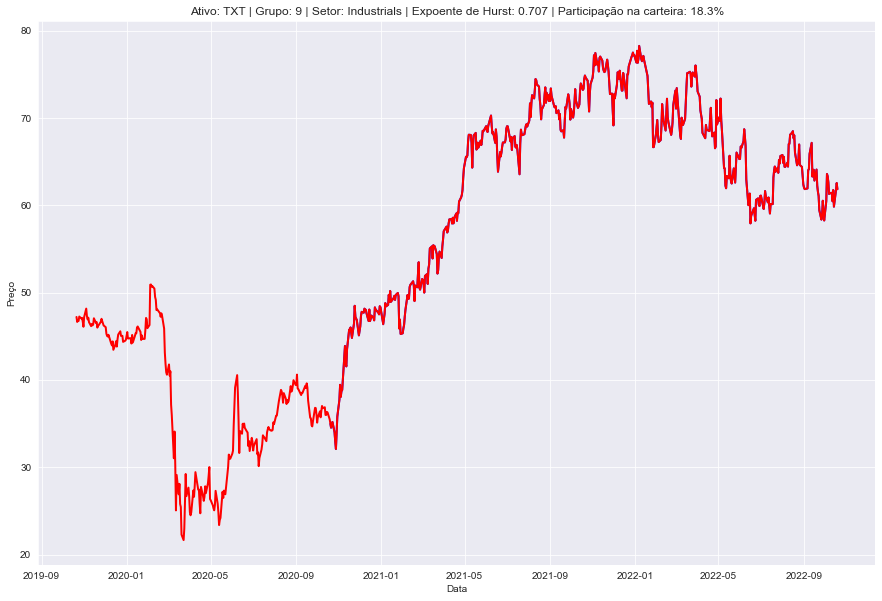

In [58]:
for ativo in choice:
    fig, ax = plt.subplots()
    ax.plot(df[ativo], linewidth=2.0, c = 'b')
    ax.plot(future[ativo], linewidth=2.0, c = 'r')
    
    ax.set_title("Ativo: {} | Grupo: {} | Setor: {} | Expoente de Hurst: {:.3f} | Participação na carteira: {:.1f}%"\
                 .format(ativo,
                         wallet.loc[ativo].Group,
                         wallet.loc[ativo].Setor,
                         wallet.loc[ativo].H,
                         100 * weight[ativo]
                        ))
    ax.set(xlabel='Data', ylabel = 'Preço')

In [59]:
growth = ((future.loc[future.index[-1], choice] / future.loc[future.index[0], choice]) -1) * 100

In [60]:
growthTable = future.loc[:, choice]
growthTable

,HSY,PTC,AMT,ORLY,OMC,PG,HII,PAYC,CVS,TXT
Dia,,,,,,,,,,
2019-10-21,153.580002,66.120003,229.399994,402.470001,75.379997,119.080002,211.009995,206.029999,65.699997,47.209999
2019-10-22,149.750000,65.940002,226.740005,400.399994,76.470001,122.180000,215.160004,190.600006,66.559998,46.639999
2019-10-23,149.710007,66.889999,226.020004,400.529999,76.720001,123.000000,217.160004,194.610001,65.599998,46.790001
2019-10-24,146.369995,69.949997,223.470001,437.299988,76.489998,124.790001,220.720001,203.500000,64.839996,46.750000
2019-10-25,143.309998,67.750000,216.669998,438.540009,76.820000,123.250000,221.190002,209.669998,65.099998,47.259998
...,...,...,...,...,...,...,...,...,...,...
2022-10-13,227.800003,108.169998,189.850006,737.979980,67.870003,126.309998,230.660004,313.440002,90.099998,61.750000
2022-10-14,222.710007,105.570000,185.779999,731.909973,66.669998,125.080002,223.169998,298.730011,89.300003,59.840000
2022-10-17,225.720001,108.389999,192.490005,736.270020,67.519997,127.339996,228.009995,315.660004,90.889999,61.750000


In [61]:
for ativo in choice:
    growthTable[ativo] = (growthTable[ativo] / growthTable[ativo][0]) * 100 * weight[ativo]

In [62]:
growthTable

,HSY,PTC,AMT,ORLY,OMC,PG,HII,PAYC,CVS,TXT
Dia,,,,,,,,,,
2019-10-21,12.723792,6.667318,5.000000,13.816654,7.492237,5.000000,13.953585,5.000000,12.050379,18.296034
2019-10-22,12.406484,6.649168,4.942023,13.745592,7.600576,5.130165,14.228015,4.625540,12.208116,18.075133
2019-10-23,12.403171,6.744962,4.926330,13.750055,7.625424,5.164595,14.360271,4.722856,12.032037,18.133265
2019-10-24,12.126458,7.053522,4.870750,15.012356,7.602564,5.239755,14.595685,4.938601,11.892641,18.117763
2019-10-25,11.872943,6.831682,4.722537,15.054925,7.635364,5.175092,14.626765,5.088337,11.940330,18.315411
...,...,...,...,...,...,...,...,...,...,...
2022-10-13,18.872769,10.907498,4.137969,25.334595,6.745797,5.303577,15.252993,7.606659,16.525710,23.930949
2022-10-14,18.451073,10.645323,4.049259,25.126213,6.626525,5.251931,14.757697,7.249673,16.378979,23.190737
2022-10-17,18.700445,10.929682,4.195510,25.275892,6.711009,5.346825,15.077754,7.660535,16.670608,23.930949


[Text(0.5, 0, 'Data'), Text(0, 0.5, 'Crescimento Percentual (%)')]

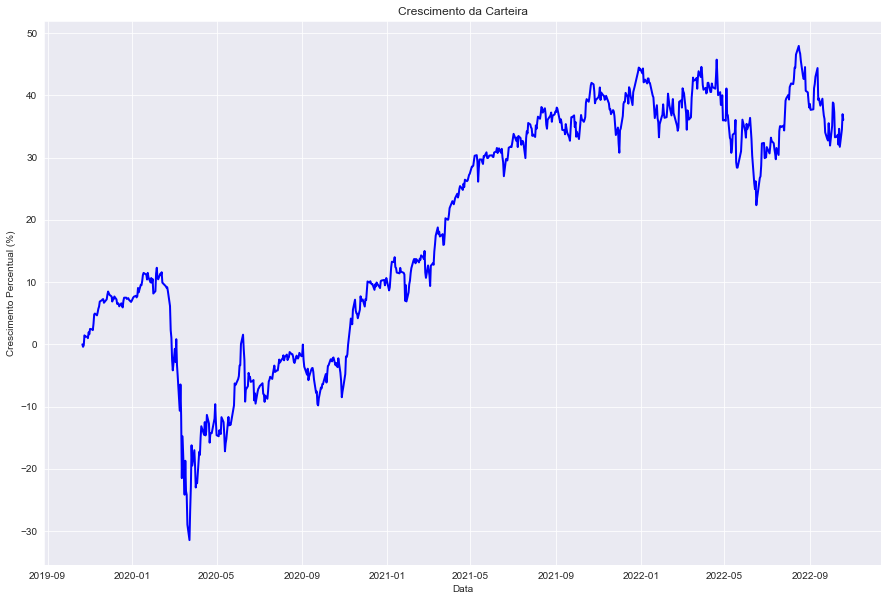

In [63]:
fig, ax = plt.subplots()
ax.plot(growthTable.sum(axis = 1) - 100, linewidth=2.0, c = 'b')

    
ax.set_title('Crescimento da Carteira')
ax.set(xlabel='Data', ylabel = 'Crescimento Percentual (%)')

In [64]:
df[choice].sum(axis = 1)

Dia
2020-10-20    1767.710011
2020-10-21    1754.400021
2020-10-22    1742.059994
2020-10-23    1771.749996
2020-10-26    1735.190006
                 ...     
2022-10-13    2153.929993
2022-10-14    2108.759991
2022-10-17    2154.040016
2022-10-18    2197.730000
2022-10-19    2178.699978
Length: 504, dtype: float64

[Text(0.5, 0, 'Data'), Text(0, 0.5, 'Preço')]

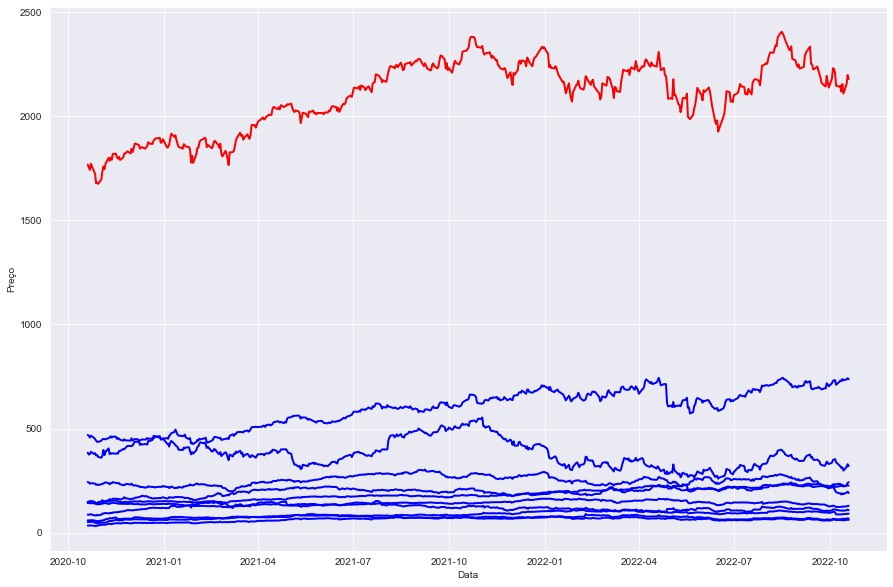

In [65]:
tot = df[choice].sum(axis = 1)

fig, ax = plt.subplots()
ax.plot(df[choice], linewidth=2.0, c = 'b')
ax.plot(tot, linewidth=2.0, c = 'r')

# .plot(future[ativo], linewidth=2.0, c = 'r')
''' 
    ax.set_title("Ativo: {} | Grupo: {} | Setor: {} | Expoente de Hurst: {:.3f} | Participação na carteira: {:.1f}%"\
                 .format(ativo,
                         wallet.loc[ativo].Group,
                         wallet.loc[ativo].Setor,
                         wallet.loc[ativo].H,
                         100 * weight[ativo]
                        ))
'''
ax.set(xlabel='Data', ylabel = 'Preço')